# Chebyshev approximation

*Author: Mohammed Ait Lahcen, Washington University in St. Louis and University of Basel*

The objective is to approximate 
$
f(x)
$
over the interval $[a,b]$ using a linear combination of Chebyshev polynomials of degree $i = 0,\dots,n$: 
$$
g(x) = \sum_{i=0}^n \alpha_i T_i\left(2 \frac{x - a}{b - a} - 1 \right).
$$

The algorithm is as follows:
1. Compute the Chebyshev nodes on $[-1,1]$. These nodes are the $m$ roots of the Chebyshev polynomial of degree $m - 1 \geq n$ and are given by:
$$
r_k = -\cos\left(\frac{2 k - 1}{2m}\pi\right) \,\, \text{for} \,\, k= 1, \dots, m.
$$
The number of nodes (data points) has to be at least equal to the number of Chebyshev polynomials used in the approximation, that is $m \geq n + 1$. The number of polynomials is the degree + 1, the degree being the highest power.

2. Map the nodes $r_k$ from the interval $[-1,1]$ to the function domain $[a,b]$:
$$
x_k = (r_k + 1) \frac{b - a}{2} + a  \,\, \text{for} \,\, k = 1, \dots, m
$$
3. Evaluate $f$ at each node $x_k$ to get:
$$
y_k = f(x_k) \,\, \text{for} \,\, k = 1, \dots, m
$$
4. Compute the $n+1$ Chebyshev coefficients $\{\alpha_i\}_0^n$ where 
$$
\alpha_i = \frac{\sum_{k=1}^{m} y_k T_i(r_k)}{\sum_{k=1}^{m} T_i(r_k)^2}
$$
If the number of nodes is equal to the number of coefficients this can be treated as a root solving problem. We can also treat it as an OLS problem which also helps us if the number of nodes is higher than the number of coefficients (i.e.\ overdetermined system):
$$
\alpha_i = \frac{cov(y, T_i(r))}{ var(T_i(r))}
$$
The OLS coefficient can be obtained in the usual way as
$$
\alpha = (X' X)^{-1} X' Y
$$
where $X$ is the [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix) of the Chebyshev polynomials evaluated at $r_k$.

5. Finally, obtain the approximation 
$$
g(x) = \sum_{i=0}^n \alpha_i T_i\left(2 \frac{x - a}{b - a} - 1 \right).
$$

*References:*

* Judd, Kenneth. L. (1998). Numerical Methods in Economics. MIT Press Books, 1.
* Collard, Fabrice. [Notes on approximation theory](http://fabcol.free.fr/pdf/lectnotes3.pdf).
* Heer, B., & Maussner, A. (2009). Dynamic general equilibrium modeling: computational methods and applications. Springer Science & Business Media.

## Example 1: approximating a function in one variable (1d case)

Let us approximate the function 
$$
f(x) = \frac{1}{3} x^3 + 2 x^2 + x - 10
$$
over the interval $[-1,3]$.

In [1]:
# Computational imports
import numpy as np
from scipy import optimize as opt
from numba import njit

# Graphics imports
import matplotlib.pyplot as plt
from matplotlib import cm # for 3d poltting
from mpl_toolkits.mplot3d.axes3d import Axes3D # for 3d poltting

In [2]:
def f(x):
    
    return 1/3 * x**3 + 2 * x**2 + x - 10


def scale_up(z,x_min,x_max):
    """
    Scales up z \in [-1,1] to x \in [x_min,x_max]
    where z = (2 * (x - x_min) / (x_max - x_min)) - 1
    """
    
    return x_min + (z + 1) * (x_max - x_min) / 2


def scale_down(x,x_min,x_max):
    """
    Scales down x \in [x_min,x_max] to z \in [-1,1]
    where z = f(x) = (2 * (x - x_min) / (x_max - x_min)) - 1
    """    
    
    return (2 * (x - x_min) / (x_max - x_min)) - 1

In [3]:
x_min = -1
x_max = 3
x_grid = np.linspace(x_min,x_max,100)

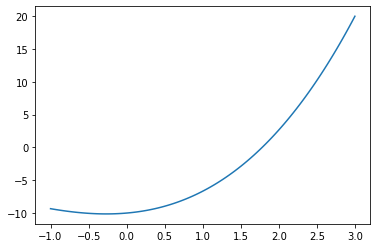

In [4]:
plt.figure()
plt.plot(x_grid,f(x_grid))
plt.show()
plt.close()

In [5]:
n = 2 # order (degree, highest power) of the approximating polynomial
m = 3 # number of Chebyshev nodes (having m > n doesn't matter for the approximation it seems)

# generate chebyshev nodes (the roots of Chebyshev polynomials, a Chebyshev polynomial of degree m-1 has m roots)
r_k = -np.cos((2*np.arange(1,m+1) - 1) * np.pi / (2*m))

# or using numpy's routine
#r_k = np.polynomial.chebyshev.chebpts1(m)

In [6]:
# builds the Vandermonde matrix of Chebyshev polynomial expansion at the r_k nodes
# using the recurrence relation
T = np.zeros((m,n+1))

T[:,0] = np.ones((m,1)).T

T[:,1] = r_k.T

for i in range(1,n):
    T[:,i+1] = 2 * r_k * T[:,i] - T[:,i-1]

# or numpy's routine
#T = np.polynomial.chebyshev.chebvander(r_k,n) 

In [7]:
# calculate the Chebyshev coefficients
x_k = scale_up(r_k,x_min,x_max)
y_k = f(x_k)
α = np.linalg.inv(T.T @ T) @ T.T @ y_k
α

array([-0.66666667, 14.        ,  6.        ])

In [8]:
# evaluate the Chebyshev series with coefficients α_k at the points r_k
T @ α

# or with numpy's routine
#np.polynomial.chebyshev.chebval(r_k,α)

array([-9.79102232, -6.66666667, 14.45768899])

In [9]:
# Use coefficients to compute an approximation of $f(x)$ over the grid of $x$:
T = np.zeros((len(x_grid),n+1))

T[:,0] = np.ones((len(x_grid),1)).T

z_grid = scale_down(x_grid,x_min,x_max)

T[:,1] = z_grid.T

for i in range(1,n):
    T[:,i+1] = 2 * z_grid * T[:,i] - T[:,i-1]

# compute approximation
Tf = T @ α

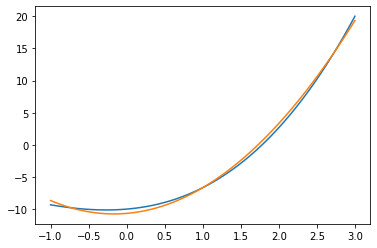

In [10]:
# make sure to use the scaled down grid inside the Chebyshev expansion
plt.figure()
plt.plot(x_grid,f(x_grid))
plt.plot(x_grid, Tf)
plt.show()
plt.close()

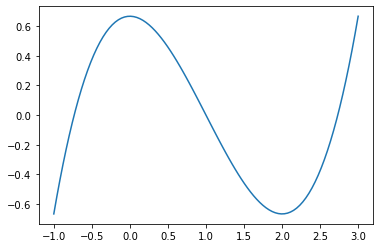

In [11]:
# plot approximation error
plt.figure()
plt.plot(x_grid,f(x_grid) - Tf)
plt.show()
plt.close()

## Example 2: approximating a function in two variables (2d case)

Let us approximate the CES function:
$$
f(x,y) = (x^\rho + y^\rho)^{\frac{1}{\rho}}
$$
using Chebyshev polynomials.

In [12]:
ρ = 0.75

def f(x,y):
    
    return (x**ρ + y**ρ) ** (1/ρ)

There are two possible ways to choose the polynomials:
- Tensor product basis,
- Complete polynomials basis.

### Using tensor product basis

In [13]:
x_min = 0.01
x_max = 2

y_min = 0.01
y_max = 2

# number of nodes
m_x = 20
m_y = 20

# order of approximating polynomial
n_x = 5
n_y = 5

In [14]:
# generate chebyshev nodes (the roots of Chebyshev polynomials, a Chebyshev polynomial of degree m-1 has m roots)
r_x = -np.cos((2*np.arange(1,m_x+1) - 1) * np.pi / (2*m_x))
r_y = -np.cos((2*np.arange(1,m_y+1) - 1) * np.pi / (2*m_y))

In [15]:
# scale up nodes to function domain
x = scale_up(r_x,x_min,x_max)
y = scale_up(r_y,y_min,y_max)

In [16]:
# build the Chebyshev polynomials for each variable separately
Tx = np.zeros((m_x,n_x+1))

Tx[:,0] = np.ones((m_x,1)).T

Tx[:,1] = r_x.T

for i in range(1,n_x):
    Tx[:,i+1] = 2 * r_x * Tx[:,i] - Tx[:,i-1]
    

Ty = np.zeros((m_y,n_y+1))

Ty[:,0] = np.ones((m_y,1)).T

Ty[:,1] = r_y.T

for i in range(1,n_y):
    Ty[:,i+1] = 2 * r_y * Ty[:,i] - Ty[:,i-1]

In [17]:
# Build matrix of f(x,y)
F = np.zeros((m_x,m_y))

for j_x in range(m_x):
    
    for j_y in range(m_y):
        
        F[j_x,j_y] = f(x[j_x],y[j_y])

In [18]:
# Compute Chebyshev coefficients
α = (Tx.T @ F @ Ty) / np.outer(np.diag(Tx.T @ Tx), np.diag(Ty.T @ Ty).T ) # use Matrix outer product for the denominator

In [19]:
# Build approximation of f(x,y)
G = Tx @ α @ Ty.T

In [20]:
np.max(np.abs(G - F))

0.011346817029381562

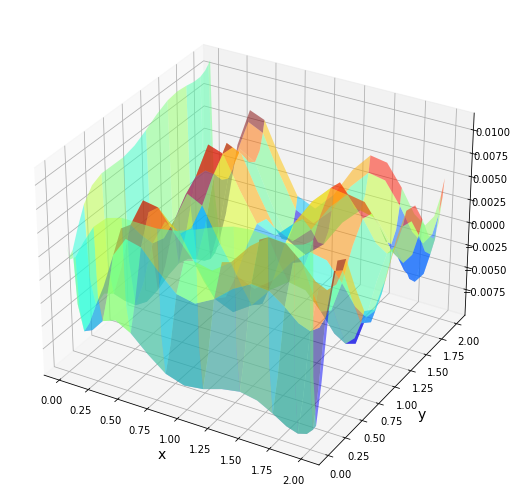

In [21]:
# Generate meshgrid coordinates for 3d plot
xg, yg = np.meshgrid(x, y)

# Plot approximation error
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg,
                yg,
                G - F,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.show()
plt.close()

### Using complete polynomials basis

When computing the coefficients we're going to use Chebyshev polynomials only up to the sum of powers to a certain order $n_x + n_y \leq \kappa$:

In [22]:
κ = n_x

α = np.zeros((n_x+1,n_y+1))

for i_x in range(n_x+1):
    
    for i_y in range(n_y+1):
        
        if i_x + i_y <= κ:
            
            α[i_x,i_y] = (Tx[:,i_x].T @ F @ Ty[:,i_y]) / np.outer(np.diag(Tx.T @ Tx)[i_x], np.diag(Ty.T @ Ty).T[i_y])

In [23]:
# Build approximation of f(x,y)
G = Tx @ α @ Ty.T

In [24]:
# Compute maximum approximation error
np.max(np.abs(G - F))

0.01537503149707975

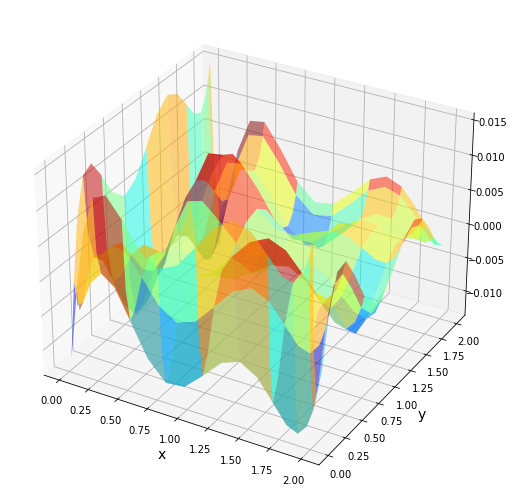

In [25]:
# Generate meshgrid coordinates for 3d plot
xg, yg = np.meshgrid(x, y)

# Plot approximation error
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xg,
                yg,
                G - F,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.show()
plt.close()